In [1]:
# import
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
import utils

import NN
import os
from torch import load as load_model
import config as cfg

In [2]:
# all data
dia_df = pd.read_csv("data/DIA.csv")
qqq_df = pd.read_csv("data/QQQ.csv")
spy_df = pd.read_csv("data/SPY.csv")

# adding suffix to all df
dia_df.columns=dia_df.columns.map(lambda x : x+'_dia' if x !='Date' else x)
qqq_df.columns=qqq_df.columns.map(lambda x : x+'_qqq' if x !='Date' else x)
spy_df.columns=spy_df.columns.map(lambda x : x+'_spy' if x !='Date' else x)

In [3]:
dfs = [dia_df, qqq_df, spy_df]

df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

# set date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
Training_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
Test_df = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
Out_of_sample_df = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

# Figure 1

In [4]:
ETF_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()

In [5]:
ETF_df

,Close_dia,Close_qqq,Close_spy
Date,,,
2011-01-03,116.410004,55.310001,127.050003
2011-01-04,116.639999,55.270000,126.980003
2011-01-05,117.040001,55.740002,127.639999
2011-01-06,116.779999,55.919998,127.389999
2011-01-07,116.570000,55.869999,127.139999
...,...,...,...
2015-04-07,178.419998,105.800003,207.279999
2015-04-08,178.750000,106.639999,207.979996
2015-04-09,179.399994,107.309998,208.899994


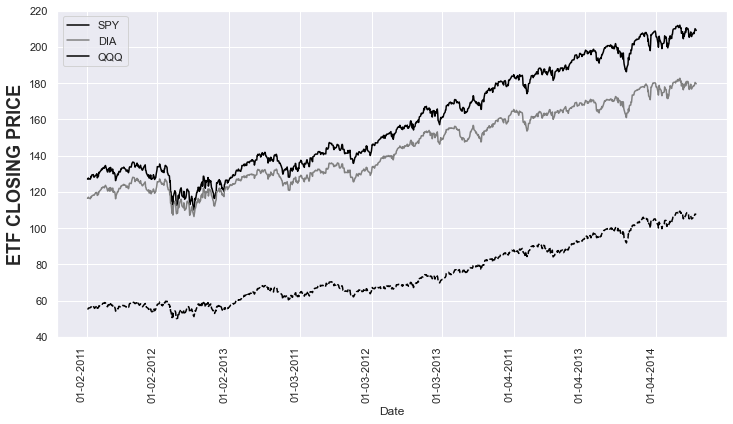

In [6]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(x=ETF_df.index, y='Close_spy', data=ETF_df, label="SPY", color='black')
sns.lineplot(x=ETF_df.index, y='Close_dia', data=ETF_df, label="DIA", color='grey')
sns.lineplot(x=ETF_df.index, y='Close_qqq', data=ETF_df, label="QQQ", color='black')

ax.lines[2].set_linestyle("--")

ax.set_ylabel('ETF CLOSING PRICE', fontsize=18, fontweight='bold')
ax.set(ylim=(40, 220))

x_dates = ETF_df.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');

plt.savefig('table/Figure1.png', bbox_inches='tight')

# Table 2

In [6]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()

ADJ_Close_table = pd.DataFrame({'Jarque-Bera stats':Total_adj_close_df.apply(utils.jarque_bera_t_stat),
                                'Jarque-Bera pval':Total_adj_close_df.apply(utils.jarque_bera_p_value),
                                'ADF stats':Total_adj_close_df.apply(utils.adf_t_stat),
                                'ADF pval':Total_adj_close_df.apply(utils.adf_p_value)
                               })

ADJ_Close_table = ADJ_Close_table.transpose()[['Adj Close_spy', 'Adj Close_dia', 'Adj Close_qqq']]
ADJ_Close_table.to_csv("table/ADJ_close_stats.csv", index=True)
ADJ_Close_table
# ADF null hypothesis = unit root 

,Adj Close_spy,Adj Close_dia,Adj Close_qqq
Jarque-Bera stats,95.254220,86.385522,99.153804
Jarque-Bera pval,0.000000,0.000000,0.000000
ADF stats,0.200271,-0.235632,0.313742
ADF pval,0.972277,0.934139,0.977966


In [7]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                                'STD':Adj_close_stats_df.apply(np.std),
                                'Skew':Adj_close_stats_df.apply(skew),
                                'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                                'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False)),
#                                 'Jarque-Bera_t_stat':Adj_close_stats_df.apply(jarque_bera_t_stat),
                                'Jarque-Bera_p_value':Adj_close_stats_df.apply(utils.jarque_bera_p_value),
#                                 'ADF_t_stat':Adj_close_stats_df.apply(adf_t_stat),
                                'ADF_p_value':Adj_close_stats_df.apply(utils.adf_p_value)})
Table2 = Adj_close_Table.transpose()[['SPY', 'DIA', 'QQQ']]

Table2.to_csv("table/Table2.csv", index=True)
Table2

,SPY,DIA,QQQ
Mean,5.443915e-04,4.971633e-04,6.659312e-04
STD,9.592380e-03,8.863505e-03,1.052343e-02
Skew,-5.687756e-01,-5.178219e-01,-4.048366e-01
Fisher_Kurtosis,5.238305e+00,4.371469e+00,3.177268e+00
Pearson_Kurtosis,8.238305e+00,7.371469e+00,6.177268e+00
Jarque-Bera_p_value,0.000000e+00,0.000000e+00,0.000000e+00
ADF_p_value,6.154752e-30,8.649508e-30,7.087245e-19


In [8]:
# Correlation matrix (Spearman's rank)
Spearman_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="spearman")

Spearman_corr.to_csv("table/Spearman_correlation.csv", index=True)
Spearman_corr

,SPY,DIA,QQQ
SPY,1.000000,0.955254,0.887686
DIA,0.955254,1.000000,0.805231
QQQ,0.887686,0.805231,1.000000


In [9]:
# Correlation matrix (Pearson's method)
Pearson_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="pearson")

Pearson_corr.to_csv("table/Pearson_correlation.csv", index=True)
Pearson_corr

,SPY,DIA,QQQ
SPY,1.000000,0.972872,0.926548
DIA,0.972872,1.000000,0.871434
QQQ,0.926548,0.871434,1.000000


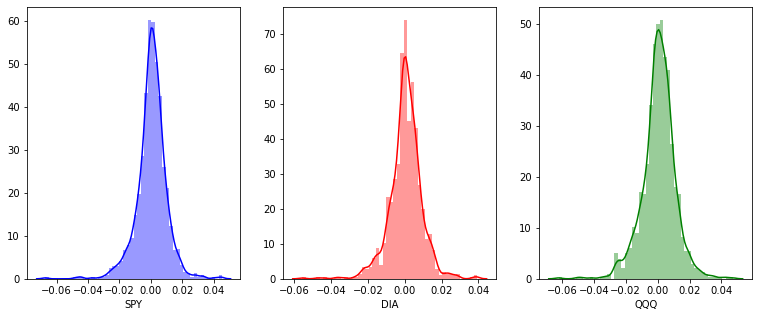

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13,5))
sns.distplot(Adj_close_stats_df["SPY"], ax=ax1, color="blue")
sns.distplot(Adj_close_stats_df["DIA"], ax=ax2, color="red")
sns.distplot(Adj_close_stats_df["QQQ"], ax=ax3, color="green")

plt.show()
fig.savefig('table/ReturnsDensityPlot.png', bbox_inches='tight')

# Table 3

In [11]:
# Table 3
datasets = ["Total data-set", "Training data-set", "Test data-set", "Out-of-sample data-set"]
trading_days = [len(Total_df), len(Training_df), len(Test_df), len(Out_of_sample_df)]
start_date = [Total_df.index[0].strftime('%d/%m/%Y'), Training_df.index[0].strftime('%d/%m/%Y'), Test_df.index[0].strftime('%d/%m/%Y'), Out_of_sample_df.index[0].strftime('%d/%m/%Y')]
end_date = [Total_df.index[-1].strftime('%d/%m/%Y'), Training_df.index[-1].strftime('%d/%m/%Y'), Test_df.index[-1].strftime('%d/%m/%Y'), Out_of_sample_df.index[-1].strftime('%d/%m/%Y')]

Table3 = pd.DataFrame({"Datasets":datasets, "Trading days":trading_days, "Start date":start_date, "End date": end_date})

Table3.to_csv("table/Table3.csv", index=False)
Table3

,Datasets,Trading days,Start date,End date
0,Total data-set,1075,03/01/2011,13/04/2015
1,Training data-set,502,03/01/2011,31/12/2012
2,Test data-set,252,02/01/2013,31/12/2013
3,Out-of-sample data-set,321,02/01/2014,13/04/2015


# Table 4

In [12]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)
        
        testmu, testsigma = df.Return.mean(), df.Return.std()
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate_bis(dataloader, testmu, testsigma) # replace by modelloaded.evaluate(dataloader, testmu, testsigma) when evaluate_bis replace evaluate
        # /!\ /!\ /!\ /!\ /!\ /!\ #
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4.csv", index=True)        

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.001197 | Test MAPE  : 119.993905 | Test RMSE : 0.000001 | Test Theil-U 0.971945
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.000053 | Test MAPE  : 5.139715 | Test RMSE : 0.000000 | Test Theil-U 0.646854
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006969 | Test MAPE  : 706.377221 | Test RMSE : 0.000049 | Test Theil-U 0.990573
Sequential(
  (0): Linear(in_features=7, out_features

In [13]:
Table4

,Statistic,MLP,RNN,PSN
ETF,,,,
SPY,MAE,1.197149e-03,5.291289e-05,6.969379e-03
SPY,MAPE,1.199939e+02,5.139715e+00,7.063772e+02
SPY,RMSE,1.435881e-06,4.674240e-09,4.857461e-05
SPY,THEIL-U,9.719453e-01,6.468544e-01,9.905726e-01
DIA,MAE,7.238306e-04,1.282125e-03,6.365531e-03
DIA,MAPE,9.789825e+01,1.670006e+02,8.572648e+02
DIA,RMSE,5.265295e-07,1.648142e-06,4.052163e-05
DIA,THEIL-U,9.624737e-01,9.781296e-01,9.913418e-01
QQQ,MAE,1.135676e-03,5.909033e-03,4.523020e-05


# Table 5

Pesaran-Timmermann test and Diebold Mariano test

In [14]:
# Pesaran-Timmermann test
#https://purehost.bath.ac.uk/ws/portalfiles/portal/189214729/Forecasting_directional_change.pdf
#https://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
#https://www.economicsnetwork.ac.uk/showcase/cook_directional
#
#
# Diebold Mariano test
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.

In [20]:
Table = pd.DataFrame()
Table_bis = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    TablePT = pd.DataFrame({"Test":"PT", "ETF":[ETF]})
    TableDM = pd.DataFrame({"Test":"DM", "ETF":[ETF]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
            inputs_PSN = cfg.SPYfeatures["PSN"]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
            inputs_PSN = cfg.DIAfeatures["PSN"]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
            inputs_PSN = cfg.QQQfeatures["PSN"]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)
        
        validmu, validsigma = df.Return.mean(), df.Return.std()
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate_bis(dataloader, validmu, validsigma) # replace by modelloaded.evaluate(dataloader, validmu, validsigma) when evaluate_bis replace evaluate
        # /!\ /!\ /!\ /!\ /!\ /!\ #
        
        if NNtype != 'PSN':
            params_PSN = cfg.train_parameters[ETF]["PSN"]
            
            features_PSN = []
            for i in inputs_PSN:
                features_PSN.append("Return_" + str(i))

            df_PSN  = utils.load_file(os.path.join("data", ETF, "PSN", "Valid.pkl"))
            dataloaderPSN = utils.DataFrame2DataLoader(df_PSN, features_PSN, target_col, batch_size=8, normalize=False)
            
            validmu_PSN, validsigma_PSN = df_PSN.Return.mean(), df_PSN.Return.std()

            PSNloaded = NN.Model("PSN")
            PSNloaded.setup(params_PSN["input_size"],
                            params_PSN["hidden_size"],
                            params_PSN["output_size"],
                            1000,#params_PSN["epochs"],
                            params_PSN["optim"],
                            params_PSN["lr"],
                            params_PSN["momentum"])
            
            PSNloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, "PSN", "ckpt.pth")))
            PSNloaded.evaluate_bis(dataloaderPSN, validmu_PSN, validsigma_PSN) # replace by PSNloaded.evaluate(dataloaderPSN, validmu_PSN, validsigma_PSN) when evaluate_bis replace evaluate
        # /!\ /!\ /!\ /!\ /!\ /!\ #
            
            PSNpred = PSNloaded.predict(dataloaderPSN, validmu_PSN, validsigma_PSN)
            pred_lst = modelloaded.predict(dataloader, validmu, validsigma)
            actual_lst = df['Target'].to_list()
            TableDM[NNtype] = utils.dm_test(actual_lst, PSNpred, pred_lst, h = 1, crit="MSE")[0]

        TablePT[NNtype] = modelloaded.testPT
        
    Table = pd.concat([Table,TablePT],ignore_index=True)
    Table_bis = pd.concat([Table_bis,TableDM],ignore_index=True)
Table5 = pd.concat([Table,Table_bis],ignore_index=True, sort=False)
# Table5.to_csv("table/Table5.csv", index=True) 

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.001197 | Test MAPE  : 119.993905 | Test RMSE : 0.000001 | Test Theil-U 0.971945
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006969 | Test MAPE  : 706.377221 | Test RMSE : 0.000049 | Test Theil-U 0.990573
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.000053 | Test MAPE  : 5.139715 | Test RMSE : 0.000000 | Test Theil-U 0.646854
PSN(
  (fc): Linear(in_features=9, out_features=5, bi

In [16]:
Table5

,Test,ETF,MLP,RNN,PSN
0,PT,SPY,50.000000,482.512168,58.260606
1,PT,DIA,50.000000,50.000000,72.076797
2,PT,QQQ,139.472965,50.000000,1535.071838
3,DM,SPY,944.252624,1138.040740,NaN
4,DM,DIA,1097.530035,960.665443,NaN
5,DM,QQQ,-117.970167,-241.938161,NaN


# Table 6

In [17]:
# preparing the risk free rate dataset ## can be added to the processdata.py ##
rf = pd.read_csv("data/Tbill.csv") # 10 year Tbill
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf.dropna(inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_rf = rf.loc[('2011-01-03' <= rf.index) & (rf.index <= '2015-04-13')]
Training_rf = rf.loc[('2011-01-03' <= rf.index) & (rf.index <= '2012-12-31')]
Test_rf = rf.loc[('2013-01-02' <= rf.index) & (rf.index <= '2013-12-31')]
Out_of_sample_rf = rf.loc[('2014-01-02' <= rf.index) & (rf.index <= '2015-04-13')]

# saving the data
Total_rf.to_csv("data/Tbill/Total.csv", index=True)
Training_rf.to_csv("data/Tbill/Train.csv", index=True)
Test_rf.to_csv("data/Tbill/Test.csv", index=True)
Out_of_sample_rf.to_csv("data/Tbill/Valid.csv", index=True)

In [18]:
riskfree = pd.read_csv("data/Tbill/Valid.csv")
rf = riskfree[['Date', 'Adj Close']].copy()
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf.rename(columns={'Adj Close':'Risk_free'}, inplace=True)

Table6 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Measure":["Annualized average returns (%)",
                                     "Cumulative return (%)",
                                     "Annualized vol (%)",
                                     "Information ratio",
                                     "Maximum Drawdown (%)",
                                     "Sharpe ratio"]
                         })
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)
        
        validmu, validsigma = df.Return.mean(), df.Return.std()
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate_bis(dataloader, validmu, validsigma) # replace by modelloaded.evaluate(dataloader, validmu, validsigma) when evaluate_bis replace evaluate
        # /!\ /!\ /!\ /!\ /!\ /!\ #
        
        preds = modelloaded.predict(dataloader, validmu, validsigma)
        targets = df['Target'].to_list()
        
        data = df[["Adj Close", "Target"]].copy()
        data["Prediction"] = preds
        data["Position"] = -1
        data.loc[data['Prediction'] > 0,'Position'] = 1
        data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
        data = data.join(rf)

        annualizedReturn = 100*252*data["Dynamic_PTF_return"].mean()
        cumulativeReturn = 100*data["Dynamic_PTF_return"].sum()
        annualizedVol = 100*np.sqrt(252)*data["Dynamic_PTF_return"].std()
        informationRatio = annualizedReturn/annualizedVol
        maximumDrawdown = utils.MDD(data, "Dynamic_PTF_return", len(data))
        
        riskfreeRate = data["Risk_free"].mean()
        sharpeRatio = (annualizedReturn - riskfreeRate)/annualizedVol       

        Table["ETF"] = ETF
        Table[NNtype] = [annualizedReturn,
                         cumulativeReturn,
                         annualizedVol,
                         informationRatio,
                         maximumDrawdown,
                         sharpeRatio]
        
    Table6 = pd.concat([Table6,Table],ignore_index=True)
Table6.set_index(["ETF"], inplace=True)
# Table6.to_csv("table/Table6.csv", index=True) 

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.001197 | Test MAPE  : 119.993905 | Test RMSE : 0.000001 | Test Theil-U 0.971945
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.000053 | Test MAPE  : 5.139715 | Test RMSE : 0.000000 | Test Theil-U 0.646854
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006969 | Test MAPE  : 706.377221 | Test RMSE : 0.000049 | Test Theil-U 0.990573
Sequential(
  (0): Linear(in_features=7, out_features

In [19]:
Table6

,Measure,MLP,RNN,PSN
ETF,,,,
SPY,Annualized average returns (%),-27.996065,21.070552,27.996065
SPY,Cumulative return (%),-27.996065,21.070552,27.996065
SPY,Annualized vol (%),11.075851,11.136800,11.075851
SPY,Information ratio,-2.527667,1.891975,2.527667
SPY,Maximum Drawdown (%),-3.748104,-1.991428,-1.991428
SPY,Sharpe ratio,NaN,NaN,NaN
DIA,Annualized average returns (%),-25.960141,-25.960141,25.960141
DIA,Cumulative return (%),-25.960141,-25.960141,25.960141
DIA,Annualized vol (%),10.115388,10.115388,10.115388


# To work

In [ ]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])
test = Total_adj_close_df.copy()

test.drop(test[(test["DIA"] == 0) | (test["QQQ"] == 0) | (test["SPY"] == 0)].index, inplace=True)

Total_adj_close_df.loc[Total_adj_close_df["SPY"]==0,:]
# test

In [18]:
ETF = 'QQQ'
Table = pd.DataFrame({"Measure":["Annualized average returns (%)",
                                     "Cumulative return (%)",
                                     "Annualized vol (%)",
                                     "Information ratio",
                                     "Maximum Drawdown (%)",
                                     "Sharpe ratio"]
                         })
NNtype = 'RNN'
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
else:
    inputs_lag = cfg.QQQfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"],
                  params["hidden_size"],
                  params["output_size"],
                  1000,#params["epochs"],
                  params["optim"],
                  params["lr"],
                  params["momentum"])
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

preds, targets = modelloaded.Getevaluation(dataloader)

data = df[["Adj Close", "Target"]].copy()
data["Prediction"] = preds
data["Position"] = -1
data.loc[data['Prediction'] > 0,'Position'] = 1
data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
data = data.join(rf)

annualizedReturn = -100*252*data["Dynamic_PTF_return"].mean()
cumulativeReturn = -100*data["Dynamic_PTF_return"].sum()
annualizedVol = 100*np.sqrt(252)*data["Dynamic_PTF_return"].std()
informationRatio = annualizedReturn/annualizedVol
maximumDrawdown = utils.MDD(data, "Dynamic_PTF_return", len(data))

riskfreeRate = data["Risk_free"].mean()
sharpeRatio = (annualizedReturn - riskfreeRate)/annualizedVol       

Table["ETF"] = ETF
Table[NNtype] = [annualizedReturn,
                 cumulativeReturn,
                 annualizedVol,
                 informationRatio,
                 maximumDrawdown,
                 sharpeRatio]
Table

RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.006885 | Test MAPE  : 18.319845 | Test RSME : 0.000083 | Test Theil-U 0.848236


,Measure,ETF,RNN
0,Annualized average returns (%),QQQ,17.806813
1,Cumulative return (%),QQQ,22.682488
2,Annualized vol (%),QQQ,13.948857
3,Information ratio,QQQ,1.276579
4,Maximum Drawdown (%),QQQ,-2.161033
5,Sharpe ratio,QQQ,1.103963


In [19]:
riskfreeRate

2.4077886435331215

In [20]:
(17.17-2.4)/1.47

10.04761904761905

In [15]:
data

,Adj Close,Target,Prediction,Position,Dynamic_PTF_return,Risk_free
Date,,,,,,
2014-01-02,81.844940,-0.007876,0.000864,1,-0.007876,2.985
2014-01-03,81.254097,-0.007245,0.001995,1,-0.007245,2.995
2014-01-06,80.953987,-0.003700,0.000524,1,-0.003700,2.961
2014-01-07,81.704262,0.009225,0.000997,1,0.009225,2.937
2014-01-08,81.882462,0.002179,-0.001447,-1,-0.002179,2.993
...,...,...,...,...,...,...
2015-04-07,100.975021,-0.001700,-0.000349,-1,0.001700,1.893
2015-04-08,101.776711,0.007908,0.003082,1,0.007908,1.895
2015-04-09,102.416145,0.006263,-0.001354,-1,-0.006263,1.958


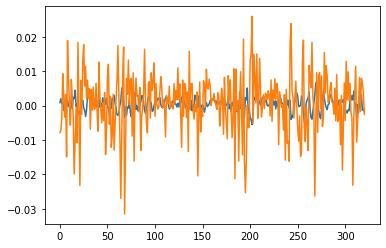

In [11]:
plt.plot(preds)
plt.plot(targets)

In [13]:
preds, targets = modelloaded.Getevaluation(dataloader)

data = df[["Adj Close", "Return_1", "Target"]].copy()
data["Prediction"] = preds

data["Position"] = -1
data.loc[data['Prediction'] > 0,'Position'] = 1

data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
data

,Adj Close,Return_1,Target,Prediction,Position,Dynamic_PTF_return
Date,,,,,,
2014-01-02,142.158234,0.005332,-0.008253,-0.003322,-1,0.008253
2014-01-03,142.400772,-0.008253,0.001705,0.000307,1,0.001705
2014-01-06,141.967697,0.001705,-0.003046,-0.000725,-1,0.003046
2014-01-07,142.903168,-0.003046,0.006568,-0.001836,-1,-0.006568
2014-01-08,142.366135,0.006568,-0.003765,0.002099,1,-0.003765
...,...,...,...,...,...,...
2015-04-07,158.730667,0.007080,-0.000952,0.000880,1,-0.000952
2015-04-08,159.024261,-0.000952,0.001848,0.000319,1,0.001848
2015-04-09,159.602463,0.001848,0.003629,0.000302,1,0.003629


In [27]:
print("Maximum drawdown (%)", (data["Dynamic_PTF_return"].min()-data["Dynamic_PTF_return"].max())/data["Dynamic_PTF_return"].max())

Maximum drawdown (%) -1.868187679087394


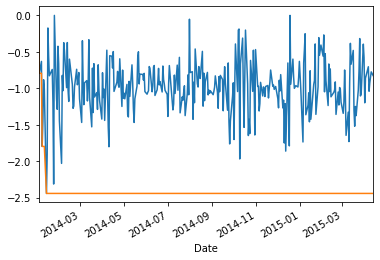

In [45]:
import matplotlib.pyplot as pp

window = len(data)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = data['Dynamic_PTF_return'].rolling(window, min_periods=1).max()
Daily_Drawdown = data['Dynamic_PTF_return']/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot() #maximum experienced 252-day drawdown
pp.show()

In [7]:
utils.MDD(data, "Dynamic_PTF_return", len(data))

-2.4403515097068236

In [22]:
Total_df[]

,Open_dia,High_dia,Low_dia,Close_dia,Adj Close_dia,Volume_dia,Open_qqq,High_qqq,Low_qqq,Close_qqq,Adj Close_qqq,Volume_qqq,Open_spy,High_spy,Low_spy,Close_spy,Adj Close_spy,Volume_spy
Date,,,,,,,,,,,,,,,,,,
2011-01-03,116.410004,116.860001,116.360001,116.410004,93.697350,9108900,54.970001,55.689999,54.950001,55.310001,50.170002,90994300,126.709999,127.599998,125.699997,127.050003,105.443665,138725200
2011-01-04,116.709999,116.730003,116.110001,116.639999,93.882401,9775600,55.509998,55.549999,54.919998,55.270000,50.133709,43851500,127.330002,127.370003,126.190002,126.980003,105.385559,137409700
2011-01-05,116.459999,117.190002,116.300003,117.040001,94.204399,7567800,55.099998,55.759998,55.070000,55.740002,50.560024,43787400,126.580002,127.720001,126.459999,127.639999,105.933296,133975300
2011-01-06,117.139999,117.190002,116.500000,116.779999,93.995064,7161600,55.799999,55.959999,55.680000,55.919998,50.723312,46139600,127.690002,127.830002,127.010002,127.389999,105.725830,122519000
2011-01-07,116.910004,117.099998,115.820000,116.570000,93.826057,9249800,56.020000,56.049999,55.320000,55.869999,50.677952,72261700,127.559998,127.769997,126.150002,127.139999,105.518341,156034600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-07,178.770004,179.580002,178.419998,178.419998,158.730667,6011600,105.919998,106.699997,105.800003,105.800003,100.975021,19379400,207.860001,208.759995,207.240005,207.279999,187.571274,81236300
2015-04-08,178.600006,179.559998,177.960007,178.750000,159.024261,4738500,105.839996,106.790001,105.830002,106.639999,101.776711,25866900,207.550003,208.509995,207.080002,207.979996,188.204712,89351900
2015-04-09,178.660004,179.630005,177.979996,179.399994,159.602463,4483800,106.589996,107.349998,106.230003,107.309998,102.416145,23114700,207.779999,209.179993,207.190002,208.899994,189.037262,85548900
